# About the Data!

## Liquipedia
[Liquipedia](https://liquipedia.net) is a community platform that records all information e-sports. All data used in this project was obtained via [liquipedia's API](https://liquipedia.net/api-terms-of-use). This project conforms to the CC-BY-SA 3.0 license used for liquipedia content representation. For more information, visit: [Liquipedia:Copyrights](https://liquipedia.net/commons/Liquipedia:Copyrights). 

## Melee Tournaments Portal
Liquipedia currently stores data for over 900 professional smash Melee tournaments and is updating regularly. This project uses 973 tournaments ranging from locals to super majors to aggregate character information. While this list is not comprehensive, it is one the best unifed databases for melee events I could find. Alternatives: Smash.gg.

#### Tournaments can be classified into several categories:
1. Locals: low # participants, no out of state entrants, low prize pool, higher frequency, typically weekly
2. Regionals: Variable # participants, medium prize pool, players from surrounding regions enter, lowish freq, monthly, or biannualy
3. Majors: High # participants, high prize pool, international representation, annual
4. SuperMajors: High # participants (with exceptions like summit), highest prize pool, many of top 100 in attendance, annual (not guaranteed)

#### Players can be classified into:
1. Top 100 ranked
2. Unrated
3. Rated players can be weighted based on their point score in the top 100 rank


#### Initial concerns with the data:
1. Falcon beats Sheik:
    1. As a falcon main, I understand both the subjective struggles and the community held belief that Falcon has a losing matchup versus Sheik. 
2. Jigglypuff reigns supreme:
    1. According to this data Jigglypuff is considered to have the best win and loss records out of all competitors. Despite there only being X players ever ranked top 100 with her out of 13 years of play.
    
** The above data points suggest that raw performance of each character are not an accurate reflection of that character's viability but are influenced by an outlier % of the top-skilled, high-ranking playerbase.**





In [293]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from pandas import Series
import pandas as pd
from pandas import DataFrame
from matplotlib import rcParams
%matplotlib inline


rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})


# Questions I want to answer:

###  Character usage:
1. ** <span style="color:green">Total matches of each char</span>**
    1. Answer: Fox is the guy
2. **<span style="color:green">Total players for each char</span>**
    1. Surprisingly it seems that there are a lot of falco players, but less matches for them
3. Compare ratio of players to total matches

###  Character win rate raw:
1. **<span style="color:green">Total win/loss of each char</span>**
    1. **<span style="color:green">Matrix based matchup chart? raw</span>**
2. Character win rates are not a suitable way of measuring character superiority:
    1. Low tier characters with very few numbers of games often have one or two wins over a high tier giving them a 70:30 record, which just ain't right. 


### ***Weighted* character win rate**
1. Compare tournament year with the ssbm rank for that year and check if any of the players are top 100
2. Weight players based on their top 100 points vs their opponent's 

### Stage Usage and win rate for each character
1. Weighted as an aggregate of the total games played, thus all stage win ratios will add to 1
2. Weight only based on win/loss weighted ratio similar to weighted character win rate
3. **<span style="color:green">Standardize points assigned to rankings for weighting</span>**

# The Goal:
Create an image like this that isn't outdated and wildly off the mark:


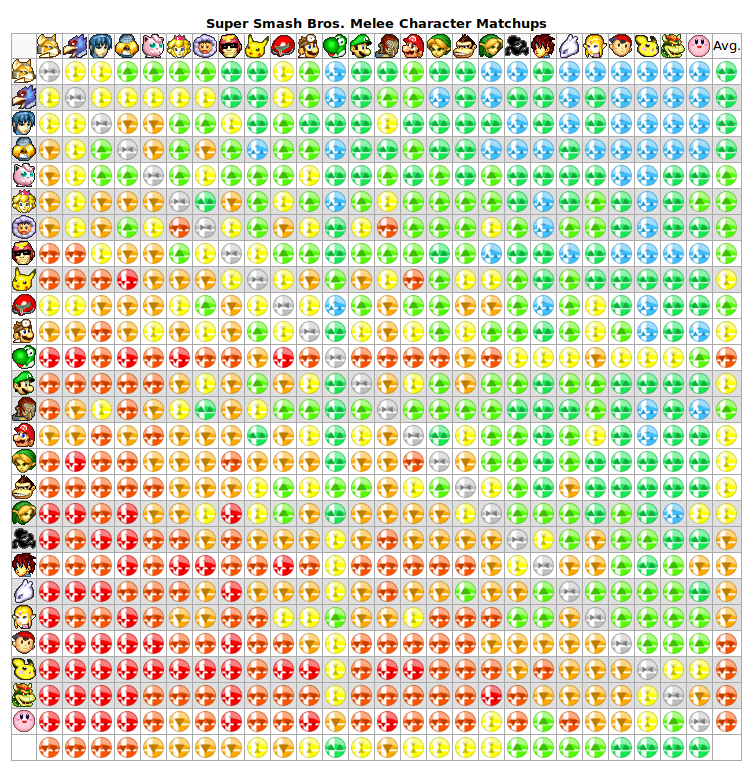

https://www.ssbwiki.com/Character_matchup_(SSBM)

In [294]:
conn = sqlite3.connect('/home/trentley/smash.db')
c = conn.cursor()

# Character usage:

# List of characters
all_characters = ['Pichu', 'Kirby', 'Zelda', 'Bowser', 'Ness', 'Roy', 'Mewtwo', 'GameandWatch_Logo_S', 'YoungLink', 'DonkeyKong', 'Link', 'DrMario', 'Mario', 'Ganondorf', 'Yoshi', 'Luigi', 'Pikachu', 'Samus', 'IceClimbers', 'Jigglypuff', 'Peach', 'CaptainFalcon', 'Falco', 'Marth', 'Sheik', 'Fox']
# Data for all recorded matches
all_matches = c.execute("""SELECT * FROM MUs""")

# Total matches recorded
total = c.execute("""SELECT MID FROM MUs ORDER BY MID DESC""").fetchone()
total = list(total)[0]

# Dictionary of characters and their usage for plotting
char_usage = {}
uchar_usage = {}


tot = 0
# Isolate all P1chars and P2chars from all matches by character, find length
for char in all_characters:
    char += '('
    char_matches = c.execute("""SELECT P1name FROM MUs WHERE P1char LIKE '%{}%'""".format(char))
    char_matches2 = c.execute("""SELECT P2name FROM MUs WHERE P2char LIKE '%{}%'""".format(char))
    
    # The names attached to each match with a player of the specified char
    names = char_matches.fetchall()
    names2 = char_matches2.fetchall()
    all_names = names + names2

    # all instances of the char played via list of their players
    players = [str(list(elem)[0]) for elem in all_names]
    if 'BYE' in players:
        players.remove('BYE')

    # only instances of the character played by a unique player via set of their players
    uplayers = set(players)

    
    # total char usage
    total_char = len(players)
    # total unique char usage
    utotal_char = len(uplayers)
    
    char = char[:-1]
    
    char_usage[char] = total_char
    uchar_usage[char] = utotal_char
    
    print(f'# of {char} matches:' + str(total_char))
    tot += total_char
    
print(tot)
c.close()

# of Pichu matches:1
# of Kirby matches:3
# of Zelda matches:4
# of Bowser matches:8
# of Ness matches:7
# of Roy matches:12
# of Mewtwo matches:22
# of GameandWatch_Logo_S matches:40
# of YoungLink matches:46
# of DonkeyKong matches:62
# of Link matches:106
# of DrMario matches:139
# of Mario matches:217
# of Ganondorf matches:269
# of Yoshi matches:440
# of Luigi matches:484
# of Pikachu matches:506
# of Samus matches:1278
# of IceClimbers matches:1936
# of Jigglypuff matches:2164
# of Peach matches:2182
# of CaptainFalcon matches:3160
# of Falco matches:3932
# of Marth matches:3838
# of Sheik matches:4139
# of Fox matches:11040
36035


All matches are recorded as **P1name, P1char(W), stage, P2name, P2char(L), tournament**

Therefore when calculating total matches played, both p1 char and p2 char columns must be searched separately and added together:

## 1) RAW character usage:

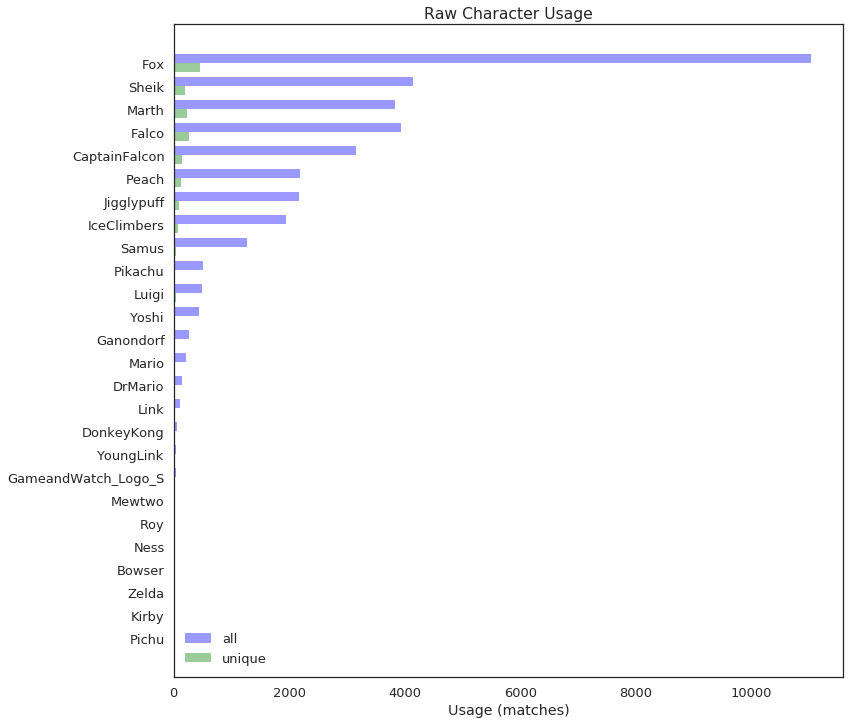

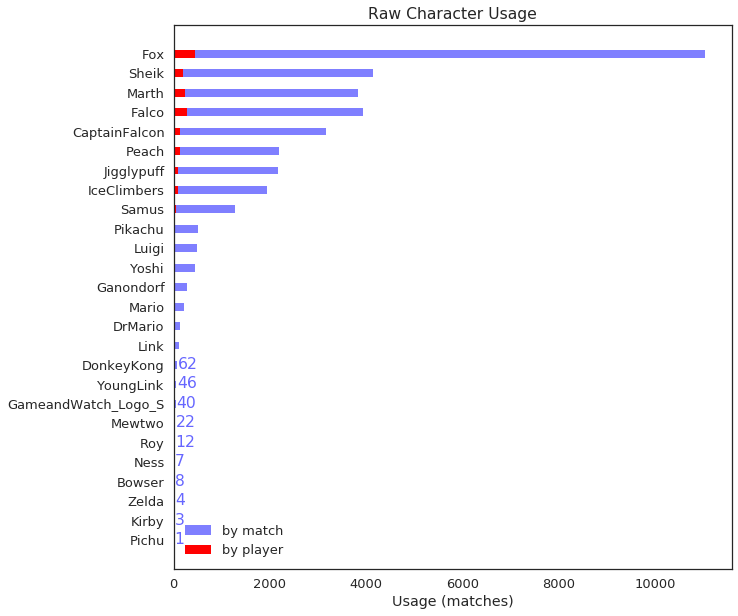

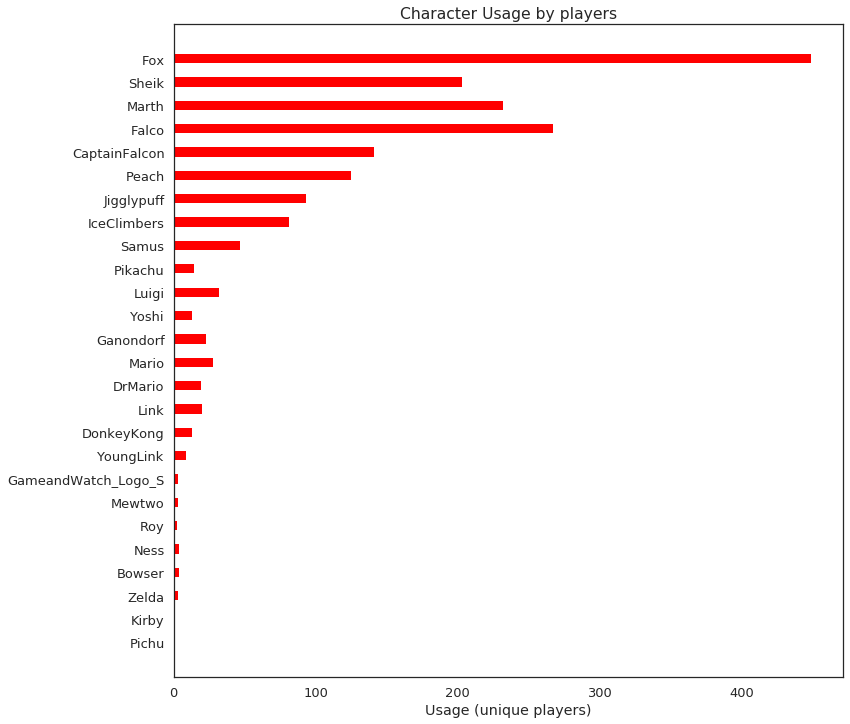

In [308]:
############ Raw Char Usage ############
chars = all_characters

# variables to plot
usage = [char_usage[i] for i in char_usage]
uusage = [uchar_usage[i] for i in uchar_usage]

# plot settings
y_pos = np.array([i for i, char in enumerate(chars)])
fig, ax = plt.subplots(figsize=(12,12),)
bar_width = .4
opacity = 0.4


# plot char usage by # matches
rects1 = plt.barh(y_pos + bar_width/2, usage, bar_width,
alpha=opacity,
color='b',
label='all')

# plot players using char
rects2 = plt.barh(y_pos - bar_width/2, uusage, bar_width,
alpha=opacity,
color='g',
label='unique')

plt.yticks(y_pos, chars)
plt.legend()
plt.xlabel('Usage (matches)')
plt.title('Raw Character Usage')


plt.show()


############ Raw Char Usage with overlap ############

# create figure and set bar vars
fig, ax = plt.subplots(figsize=(10,10),)
bar_width = .4
opacity = 0.5

# first series of bars
rects1 = plt.barh(y_pos, usage, bar_width,
alpha=opacity,
color='b',
label='by match')

# second series of bars
rects2 = plt.barh(y_pos, uusage, bar_width,
alpha=1,
color='r',
label='by player')
plt.yticks(y_pos, chars)
plt.legend()

# barlabels for small bars
for i, v in enumerate(usage):
    if v <= 100:
        ax.text(v + 20, i - .2, str(v), color='blue', alpha=.6)

# label and plot    
plt.xlabel('Usage (matches)')
plt.title('Raw Character Usage')
plt.show()



############ Characters by Players ############

# create figure and set bar vars
fig, ax = plt.subplots(figsize=(12,12),)
bar_width = .4
opacity = 0.5

# second series of bars
rects2 = plt.barh(y_pos, uusage, bar_width,
alpha=1,
color='r')
plt.yticks(y_pos, chars)


# label and plot    
plt.xlabel('Usage (unique players)')
plt.title('Character Usage by players')
plt.show()


This plot tells me that the number of players maining these characters is far smaller than the number of matches that involve the characters. It would be interesting to see if the ratio of total players is similar to the match distribution.

###### 2) Win/Loss Ratio

In [296]:
# enter two characters, find the win loss ratio between them and the stages they most commonly win on

def ratio(char1, char2):
    conn = sqlite3.connect('/home/trentley/smash.db')
    c = conn.cursor()

    wins = 0
    losses = 0

    # query all matches in the db
    query_matches = """SELECT P1name, P1char, Stage, P2name, P2char FROM `MUs` WHERE `P1char` LIKE ? 
    AND `P2char` LIKE ? ORDER BY `_rowid_` ASC LIMIT 0, 50000"""
    matchup = ('%' + char1 + '(%', '%' + char2 + '(%')
    rmatchup = matchup[::-1]

    bf = [0,0]
    dl = [0,0]
    ys = [0,0]
    fod = [0,0]
    ps = [0,0]
    fd = [0,0]
    stage_win = []
    stage_loss = []

    for match in c.execute(query_matches, matchup):
        if match[1] == char1 + '(W)':
            wins += 1
            stage_win.append(match[2])
        if match[1] == char1 + '(L)':
            losses += 1
            stage_loss.append(match[2])

    for match in c.execute(query_matches, rmatchup):
        if match[4] == char1 + '(W)':
            wins += 1
            stage_win.append(match[2])
        if match[4] == char1 + '(L)':
            losses += 1
            stage_loss.append(match[2])
    try:
        p1_ratio = round((wins / (wins + losses)) * 100)
        p2_ratio = 100 - p1_ratio


    except ZeroDivisionError:
        p1_ratio = None
        p2_ratio = None
    
    c.close()
    return p1_ratio
    #     print("\n\n{} vs {}\n {} wins: {}, losses: {} \n {} {}:{} {}".format(char1, char2, char1, wins, losses, char1, p1_ratio, p2_ratio, char2))

#     for stage in stage_loss:
#         if stage == "Battlefield":
#             bf[0] += 1
#         if stage == "Dream Land":
#             dl[0] += 1
#         if stage == "Fountain of Dreams":
#             fod[0] += 1
#         if stage == 'Pokémon Stadium':
#             ps[0] += 1
#         if stage == "Final Destination":
#             fd[0] += 1
#         if stage == "Yoshi's Story":
#             ys[0] += 1

#     for stage in stage_win:
#         if stage == "Battlefield":
#             bf[1] += 1
#         if stage == "Dream Land":
#             dl[1] += 1
#         if stage == "Fountain of Dreams":
#             fod[1] += 1
#         if stage == 'Pokémon Stadium':
#             ps[1] += 1
#         if stage == "Final Destination":
#             fd[1] += 1
#         if stage == "Yoshi's Story":
#             ys[1] += 1

#     try:
#         print(f'{char1} Final Destination win val: {(100 * fd[1] / (fd[1] + fd[0])) - p1_ratio}')
#     except ZeroDivisionError:
#         pass
#     try:
#         print(f'{char1} Pokemon Stadium win val: {(100 * ps[1] / (ps[1] + ps[0])) - p1_ratio}')
#     except ZeroDivisionError:
#         pass
#     try:
#         print(f'{char1} Yoshi Story  win val: {(100 * ys[1] / (ys[1] + ys[0])) - p1_ratio}')
#     except ZeroDivisionError:
#         pass
#     try:
#         print(f'{char1} Fountain  win val: {(100 * fod[1] / (fod[1] + fod[0])) - p1_ratio}')
#     except ZeroDivisionError:
#         pass
#     try:
#         print(f'{char1} Dream Land  win val: {(100 * dl[1] / (dl[1] + dl[0])) - p1_ratio}')
#     except ZeroDivisionError:
#         pass
#     try:
#         print(f'{char1} Battlefield  win val: {(100 * bf[1] / (bf[1] + bf[0])) - p1_ratio}')
#     except ZeroDivisionError:
#         pass
    # staged = {"Battlefield" : bf, "Dreamland": dl, "Fountain of Dreams": fod, "Pokémon Stadium": ps, "Yoshi's Story": ys}
    # for i in staged:
    #     print(staged[i])




In [297]:
conn = sqlite3.connect('/home/trentley/smash.db')
c = conn.cursor()

def winloss(char):

    wins = 0
    losses = 0

    # query all wins
    q1 = """SELECT `_rowid_`,* FROM `MUs` WHERE P1name NOT LIKE '%BYE%' AND P1char LIKE ? AND P2name NOT LIKE '%BYE%' AND P2char NOT LIKE ? ORDER BY P1name ASC LIMIT 0, 50000;"""
    q2 = """SELECT `_rowid_`,* FROM `MUs` WHERE P1name NOT LIKE '%BYE%' AND P1char NOT LIKE ? AND P2name NOT LIKE '%BYE%' AND P2char LIKE ? ORDER BY `P2name` ASC LIMIT 0, 50000;"""
    character = ('%' + char + '(%', '%' + char + '(%')
    character_wins = ('%' + char + '(W%', '%' + char + '(W%')

    
    total_matches = len(c.execute(q1, character).fetchall()) + len(c.execute(q2, character).fetchall())
    wins = len(c.execute(q1, character_wins).fetchall()) + len(c.execute(q2, character_wins).fetchall())
    ratio = wins / total_matches
    print(f'{char}: {total_matches}, wins: {wins}, ratio: {ratio}')
    return ratio

win_ratio = {}

for char in chars:
    win_ratio[char] = winloss(char)

print(win_ratio)
c.close()


Pichu: 4, wins: 1, ratio: 0.25
Kirby: 9, wins: 5, ratio: 0.5555555555555556
Zelda: 11, wins: 4, ratio: 0.36363636363636365
Bowser: 9, wins: 0, ratio: 0.0
Ness: 17, wins: 6, ratio: 0.35294117647058826
Roy: 13, wins: 2, ratio: 0.15384615384615385
Mewtwo: 43, wins: 14, ratio: 0.32558139534883723
GameandWatch_Logo_S: 62, wins: 22, ratio: 0.3548387096774194
YoungLink: 76, wins: 31, ratio: 0.40789473684210525
DonkeyKong: 99, wins: 45, ratio: 0.45454545454545453
Link: 180, wins: 64, ratio: 0.35555555555555557
DrMario: 267, wins: 105, ratio: 0.39325842696629215
Mario: 371, wins: 144, ratio: 0.3881401617250674
Ganondorf: 490, wins: 224, ratio: 0.45714285714285713
Yoshi: 908, wins: 494, ratio: 0.5440528634361234
Luigi: 833, wins: 353, ratio: 0.4237695078031212
Pikachu: 1054, wins: 566, ratio: 0.5370018975332068
Samus: 2486, wins: 1185, ratio: 0.4766693483507643
IceClimbers: 3382, wins: 1703, ratio: 0.5035481963335304
Jigglypuff: 4353, wins: 2533, ratio: 0.5818975419251091
Peach: 4763, wins: 2635

## RAW win rate:

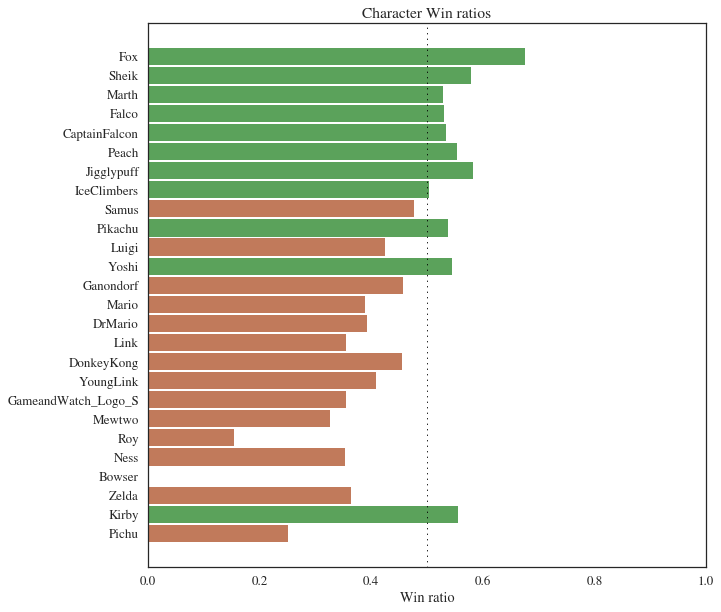

In [298]:
# set positions for yticks/labels
y_pos = np.array([i for i, char in enumerate(chars)])

ratio = [win_ratio[i] for i in win_ratio]

# create figure and set bar vars
fig, ax = plt.subplots(figsize=(10,10),)
bar_width = .9
opacity = 0.4

# first series of bars
rects1 = plt.barh(y_pos, ratio, bar_width,
alpha=opacity,
color='g')



# plot bar graph and change color for ratios worse than even
for i, pos in enumerate(y_pos):
    if ratio[i] < .5:
        color = 'r'
    else:
        color = 'darkgreen'
    plt.barh(pos, ratio[i], bar_width, alpha=opacity, color=color)

# add dotted line at .5 ratio
plt.axvline(x=.5, linewidth=1, color='black', dashes=(0.5, 5.), dash_capstyle = 'round')

# set the min/max values for figure
ax.set_xlim([0,1])

# plt the ticks and y values
plt.yticks(y_pos, chars)

# label and plot    
plt.xlabel('Win ratio')
plt.title('Character Win ratios')
plt.show()



['Pichu', 'Kirby', 'Zelda', 'Ness', 'Bowser', 'Roy', 'Mewtwo', 'GameandWatch_Logo_S', 'YoungLink', 'DonkeyKong', 'Link', 'DrMario', 'Mario', 'Ganondorf', 'Yoshi', 'Luigi', 'Pikachu', 'Samus', 'IceClimbers', 'Jigglypuff', 'Peach', 'CaptainFalcon', 'Marth', 'Falco', 'Sheik', 'Fox']


[]

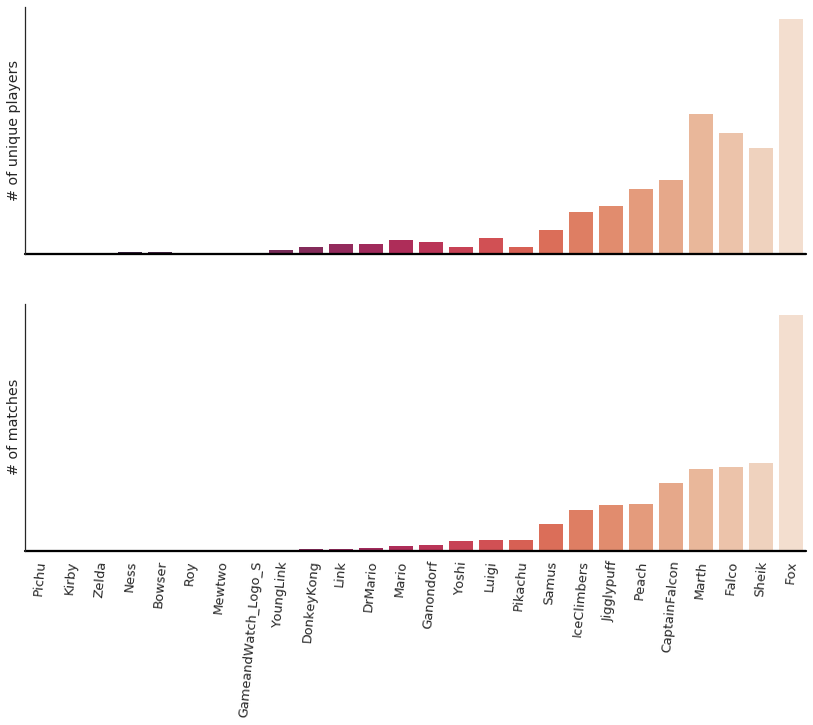

In [299]:
char_usage = {}
for count, num in enumerate(usage):
    char_usage[chars[count]] = num
    
    
a = sorted(char_usage.items(), key=lambda x: x[1]) 
vals = dict(a).values()
keys = dict(a).keys()

print(list(keys))
sns.set(style="white", context="talk")

# Set up the matplotlib figure
f, (ax3, ax1) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Generate some sequential data
x = np.array(list(keys))
y3 = np.array(list(uusage))
y1 = np.array(list(vals))

# Randomly reorder the data to make it qualitative
sns.barplot(x=x, y=y3, palette="rocket", ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("# of unique players")
plt.xticks(rotation=85)

sns.barplot(x=x, y=y1, palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("# of matches")


# Finalize the plot
sns.despine(bottom=True)

plt.setp(f.axes, yticks=[])



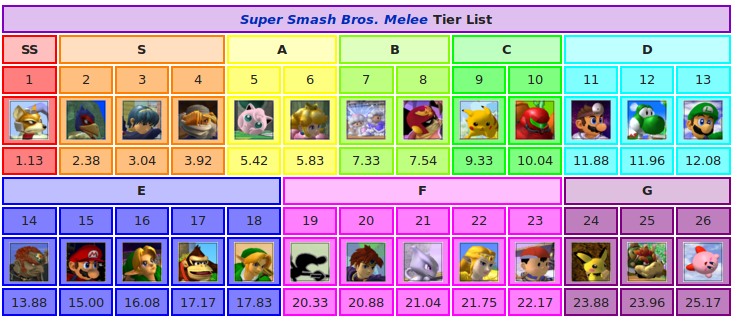
<span style="center" color="blue">Image taken from: https://www.ssbwiki.com/List_of_SSBM_tier_lists_(NTSC)</span>

This dataset is pretty funny. It gives me a taste that large datasets can yield real insight with predictive capabilities, but in the same fell swoop, are absurd without fine tuning. When looking at these results it is interesting to note that **the top 9 characters of the 2015 ssbm wiki tier list**, a rating system measuring viability of tournament play for each character determined by a panel of respected players and analysts, ***near exclusively* perform with a positive win/loss record**. This would support the belief that the dataset is a robust measurement of the characters' *viability* as it matches the community standards for the best characters' predicted performance. *However,* there is one major issue with the results. **Kirby**. Kirby appears to have one of the top 5 highest win ratios, while ranked firmly at the bottom of the tier list. In recent years debate has suggested kirby's placement is too low, but this new placement is still within the bottom 5, much less the top 5. Based on this evidence, it appears that the data has some predictive power but is ultimately problematic. 

Let's explore that.

## Problems with data:

#### 1) Low Tiers: Low Sample Size
The immediate concern I have with kirby and most of the other lower tiers comes from char usage by match of Figure 1. It seems that the knowledge imparted by this tier list is either self-evident in tournament play or has been followed so religiously that all tournament players solely main characters from the higher tiers. After Captain Falcon there is a steep drop off in the number of matches played for each lower tiered characted. By the time you reach Kirby... there are only 9 recorded games of kirby players in the data set. This low sample size causes any results to be much more prone to randomness.

##### Possible Solution: Focus only on characters with moderate to high usage.

#### 2) Player Skill DIfferentials
A second problem with this data set is that there are only uniform records of character matchups in the top 32's of bracket. This means that to even get to a point where a player and their character are reported they must have won their pools and preliminary bracket matches. This is where the majority of players drown in anonymity. Therefore the ones recorded by these visualizations are already in a certain subset of skill: quite higher than the average ssbm tournament attendant.

This context adds another possible interpretation of the data, that the low usage of some characters is not actually a representation of their usage but a representation of their lower skill ceilings, indicating that they did not make it to the end of their bracket. However, it is likely a mix of several factors.

##### Possible solution: Weight ranked players, or ignore unranked players. Find mu's of top players off of their mean w/l ratio. 
1. Weight players that play matches based on ssbmrank. High rank differential wins mean less value attributed to the character's win over another.

2. Look into top players' win loss record vs other top players. This sample size may be smaller but could reduce the amount of player skill differentials. It also would be interesting to see the top players' ability to push the envelope with a character and then determine the relative percent of win/loss score around the mean w/l ratio they have to determine positive and negative matchups. 


## Initial thoughts on Weighting

The above cell includes a customizable query of matches that tracks players, their ranking of the year, and that year's associated points. Unfortunately the **points have not yet been standardized.** The next step is to come up with a method of weighting these points to give a more accurate estimate of the relative character matchups, by reducing the impact of victories won via skill landslides. 

I once took eggz (rank 73) to his final stock on marth at tournament and his fox to about 2/3 stocks. Around this time, Dashizwiz (rank 30) defeated eggz 2 stocks and 3 stocks. This same year, Mango defeated Shiz JV3 and 3.


Therefore, me, a fringe unranked player, took about 1/2 the stocks off of a 73rd ranked player as he took off me. Thus it could be said that Eggz = 2x me(unrated). Dashizwiz(30) = 2x Eggz(73). Mango(1) = 4x DSW(30). As you reach the top the competition becomes non-linearly more fierce. Thus we could say Mango is 16x better at taking stocks than I am. Does this mean we need to rank the top players' games against unrated players 16 times less than two unknown unrated players? Looking at Mango's point total for 2013, he has the perfect 10.0. DSW is 7.778 and Eggz is 7.006. These points obviously represent a voting panel's mean tally to determine ranking based on their idea of performance, and don't seem to follow my scenario of stock taking comparisons. Eggz and DSW are more closely ranked than my initial metric and Mango's rating also doesn't seem as severe. 

### Top players' matches have more weight because they play the most matches in this data set:
Looking at the number of matches played reveals:

1) **Mango** common world top 3 **has played in 1137 recorded matches out of the 31070** total recorded.
To a one off player, his results essentially are 1137 times more prominent in the character matchup. His weighting should be adjusted accordingly. Given this logic, a 16x reduction doesn't seem so significant. Therefore it feels that modern day understanding knowledge of character matchups is also largely based on the results of the highest echelon of players.




In [240]:
# TOTAL NUMBER OF TOP PLAYERS AND THEIR MATCHES

conn = sqlite3.connect('/home/trentley/smash.db')
c = conn.cursor()

# Find all players ever in top 100:
all_top = c.execute("""SELECT Name FROM SSBMRank""").fetchall()
all_top = [str(list(elem)[0]) for elem in all_top]

# All recorded top players
all_top = set(all_top) 

# Find all recorded players
all_players1 = c.execute("""Select P1name FROM MUs""").fetchall()
all_players2 = c.execute("""Select P2name FROM MUs""").fetchall()
all_players1 = [str(list(elem)[0]) for elem in all_players1]
all_players2 = [str(list(elem)[0]) for elem in all_players2]

# All recorded players
all_players = all_players1 + all_players2
all_players = set(all_players)


# prints the number of recorded matches a specified player has played
def profile(player):

    # Total matches recorded
    total = c.execute("""SELECT * FROM MUs WHERE P1name LIKE "{}" or P2name Like "{}" """.format(player, player))
    total = len(total.fetchall())

    if total is None:
        total = 0
    return total

mtches = 0
print('processing')

# for player in all_top:
    
#     if "'" in player:
#         continue
#     val = profile(player)
    

#     mtches += val
    
# print(mtches)

print(45811/63471)


c.close()

processing
0.7217626947739912


Create a profile for top 100 players including their number of matches played and w/l for each character as a means to better understand their impact on this data set. Measure unrated player success.

#### Results:
1) There have been 222 different top 100 players over the 6 years the rankings have been out. It seems that the top players are a narrow margin of the smash community

2) There are 1398 TOTAL recorded players, including the 222 top ranked.

##### Therefore the top players make up about 16% of the total recorded playerbase. However, how much of the matchbase do they make up?

45811/63471... I have no idea why the total matches is inflated by ~ 1000 matches... It should be 62070 as that is 2x the total matches stored... **Regardless matches involving top ranked players make up 72% of the dataset. **


### <span style="color:green">Next step: Standardize SSBMRank points for weightings</span>


## What exactly defines a character's matchup is debated, but is often thought of as the distribution of wins and losses between two characters given an equal skill level of their players. 

In [19]:
top_tiers = ["Fox", "Falco", "Marth", "Jigglypuff", "Sheik", "Peach", "CaptainFalcon", "IceClimbers", "Pikachu", "Samus", "Yoshi", "DrMario"]
mus = np.zeros((len(top_tiers), len(top_tiers)))



print(ratio('Fox', 'Falco'))
for i, char1 in enumerate(top_tiers):
    for j, char2 in enumerate(top_tiers):
        mus[j][i] = ratio(char2, char1)
        


# print(mus)

50


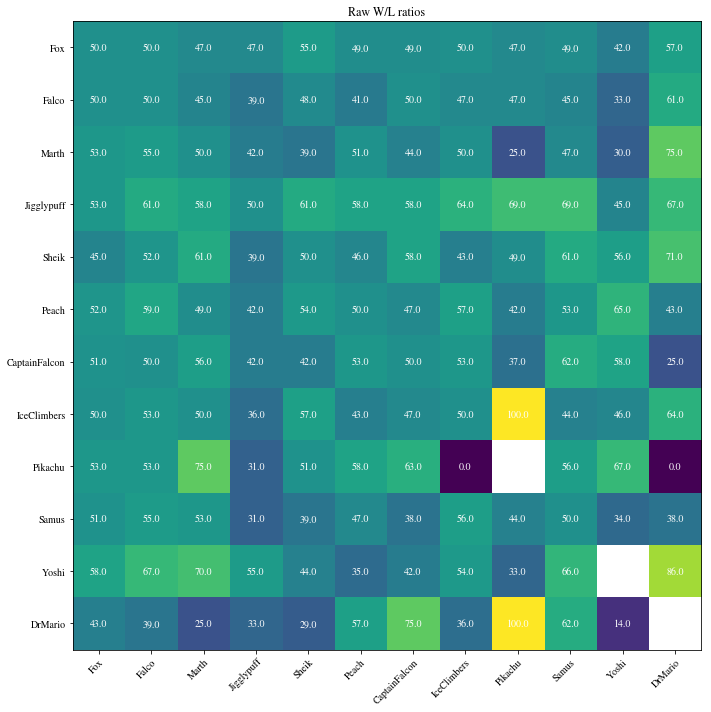

In [21]:
#### HEATMAP GRAPH

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(mus)

# We want to show all ticks...
ax.set_xticks(np.arange(len(top_tiers)))
ax.set_yticks(np.arange(len(top_tiers)))
# ... and label them with the respective list entries
ax.set_xticklabels(top_tiers)
ax.set_yticklabels(top_tiers)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(top_tiers)):
    for j in range(len(top_tiers)):
        text = ax.text(j, i, mus[i, j],
                       ha="center", va="center", color="white")
        


ax.set_title("Raw W/L ratios")
fig.tight_layout()

plt.show()

In [136]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color='white')
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

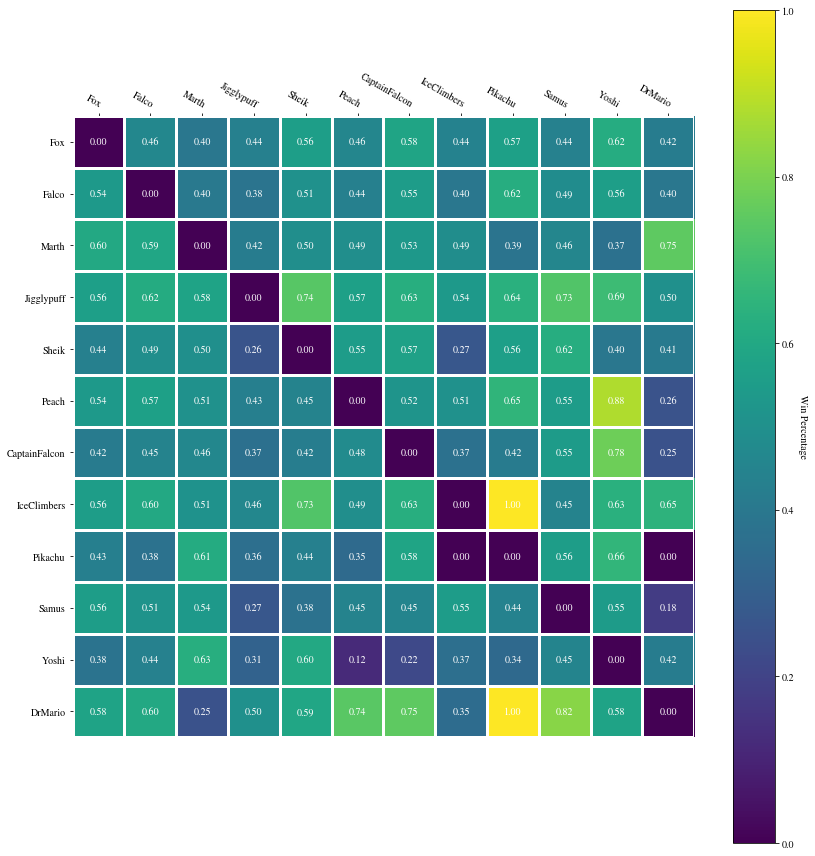

In [138]:
fig, ax = plt.subplots(figsize=(12,12))

im, cbar = heatmap(wmus, top_tiers, top_tiers, ax=ax,
                   cmap="viridis", cbarlabel="Win Percentage")
texts = annotate_heatmap(im)

fig.tight_layout()
plt.show()


In [ ]:
stages = ["Battlefield", "Dream Land", "Fountain of Dreams", "Pokémon Stadium", "Final Destination", "Yoshi's Story"]

# list of all recorded players -> all_players

In [310]:
# Let's see if we can join a player match to the player's ranking and points if they exists

class Player:
    def __init__(self, name, char, win):
        self.name = name
        self.char = char
        self.win = win
        self.rank = None
        self.points = 1


conn = sqlite3.connect('/home/trentley/smash.db')
c = conn.cursor()

def winloss(char1, char2):
    if char1 == char2:
        return 0
    
    wins = 0
    losses = 0

    # MUs INFO with DATES from TOURNAMENTS
    match = """SELECT P1name, P1char, P2name, P2char, Tournament, Name, Date FROM [MUs] JOIN TOURNAMENTS ON [MUs].Tournament = Tournaments.Name
    WHERE P1char LIKE '%{}(%' AND P2char LIKE '%{}(%' OR P2char LIKE '%{}(%' AND P1char LIKE '%{}(%';
    """.format(char1, char2, char1, char2)
    
    matchdf = pd.read_sql_query(match, conn)
    # take names from matches and the date they occurred    
    for index in matchdf.index:
        p1char = matchdf.loc[index, "P1char"]
        p2char = matchdf.loc[index, "P2char"]
        p1name = matchdf.loc[index, "P1name"]
        p2name = matchdf.loc[index, "P2name"]
        
        
        # p1 will ALWAYS BE char1, thus win/loss ratio is for char1, 100-ratio = char2's
        if p1char[:-3] == char1:
            p1 = Player(name=p1name, char=p1char[:-3], win=p1char[-2])
            p2 = Player(name=p2name, char=p2char[:-3], win=p2char[-2])
        else:
            p1 = Player(name=p2name, char=p2char[:-3], win=p2char[-2])
            p2 = Player(name=p1name, char=p1char[:-3], win=p1char[-2])
            

        period = matchdf.loc[index, "Date"]
        match_year = period[-4:]
        
        # SSBMRanks INFO
        ssbmrank = """SELECT Rank, Name, Points FROM SSBMRANK WHERE Name LIKE "{}" AND Year LIKE "{}" OR Name Like "{}" AND Year LIKE "{}";""".format(p1name, match_year, p2name, match_year)
        
        rankdf = pd.read_sql_query(ssbmrank, conn)
        
        if len(rankdf.index) >= 1:
            name1 = rankdf.values[0][1]
            if name1 == p1.name:
                p1.rank = rankdf.values[0][0]
                p1.points = rankdf.values[0][2]
            else:
                p2.rank = rankdf.values[0][0]
                p2.points = rankdf.values[0][2]

            if len(rankdf.index) == 2:
                name2 = rankdf.values[1][1]
                if name2 == p2.name:
                    p2.rank = rankdf.values[1][0]
                    p2.points = rankdf.values[1][2]
                else:
                    p1.rank = rankdf.values[1][0]
                    p1.points = rankdf.values[1][2]
               
        # Weight match and add to win and loss ratio
        if p1.points > p2.points:
            weight = p1.points**2 / p2.points**2
            if weight > 10:
                weight = 10
            if p1.win == 'W':
                weight = 1/weight
                
        elif p2.points > p1.points:
            weight = p2.points**2 / p1.points**2
            if weight > 10:
                weight = 10
            if p2.win == 'W':
                weight = 1/weight
        
        else:
            weight = 1
        if p1.win == 'W':
            wins += weight
        if p1.win == 'L':
            losses += weight

        
#         print(f"{weight} --- {p1.name} {p1.char}({p1.win}) vs. {p2.name} {p2.char}({p2.win}) ----- {match_year}")
    try:
        ratio = wins/(wins + losses)
        ratio = round(ratio, 2)
    except ZeroDivisionError:
        ratio = 0
    print(ratio)
    return ratio


c.close()

In [311]:
wmus = np.zeros((len(top_tiers), len(top_tiers)))



for i, char1 in enumerate(top_tiers):
    for j, char2 in enumerate(top_tiers):
        wmus[j][i] = winloss(char2, char1)
        print(char2,char1)
        



Fox Fox
0.55
Falco Fox
0.62
Marth Fox
0.58
Jigglypuff Fox
0.4
Sheik Fox
0.56
Peach Fox
0.4
CaptainFalcon Fox
0.57
IceClimbers Fox
0.4
Pikachu Fox
0.59
Samus Fox
0.32
Yoshi Fox
0.65
DrMario Fox
0.45
Fox Falco
Falco Falco
0.58
Marth Falco
0.51
Jigglypuff Falco
0.47
Sheik Falco
0.55
Peach Falco
0.46
CaptainFalcon Falco
0.64
IceClimbers Falco
0.31
Pikachu Falco
0.53
Samus Falco
0.39
Yoshi Falco
0.74
DrMario Falco
0.37
Fox Marth
0.41
Falco Marth
Marth Marth
0.58
Jigglypuff Marth
0.45
Sheik Marth
0.49
Peach Marth
0.43
CaptainFalcon Marth
0.47
IceClimbers Marth
0.54
Pikachu Marth
0.55
Samus Marth
0.62
Yoshi Marth
0.46
DrMario Marth
0.42
Fox Jigglypuff
0.49
Falco Jigglypuff
0.42
Marth Jigglypuff
Jigglypuff Jigglypuff
0.2
Sheik Jigglypuff
0.36
Peach Jigglypuff
0.38
CaptainFalcon Jigglypuff
0.44
IceClimbers Jigglypuff
0.23
Pikachu Jigglypuff
0.3
Samus Jigglypuff
0.22
Yoshi Jigglypuff
0.42
DrMario Jigglypuff
0.59
Fox Sheik
0.53
Falco Sheik
0.54
Marth Sheik
0.8
Jigglypuff Sheik
Sheik Sheik
0.41
Pe

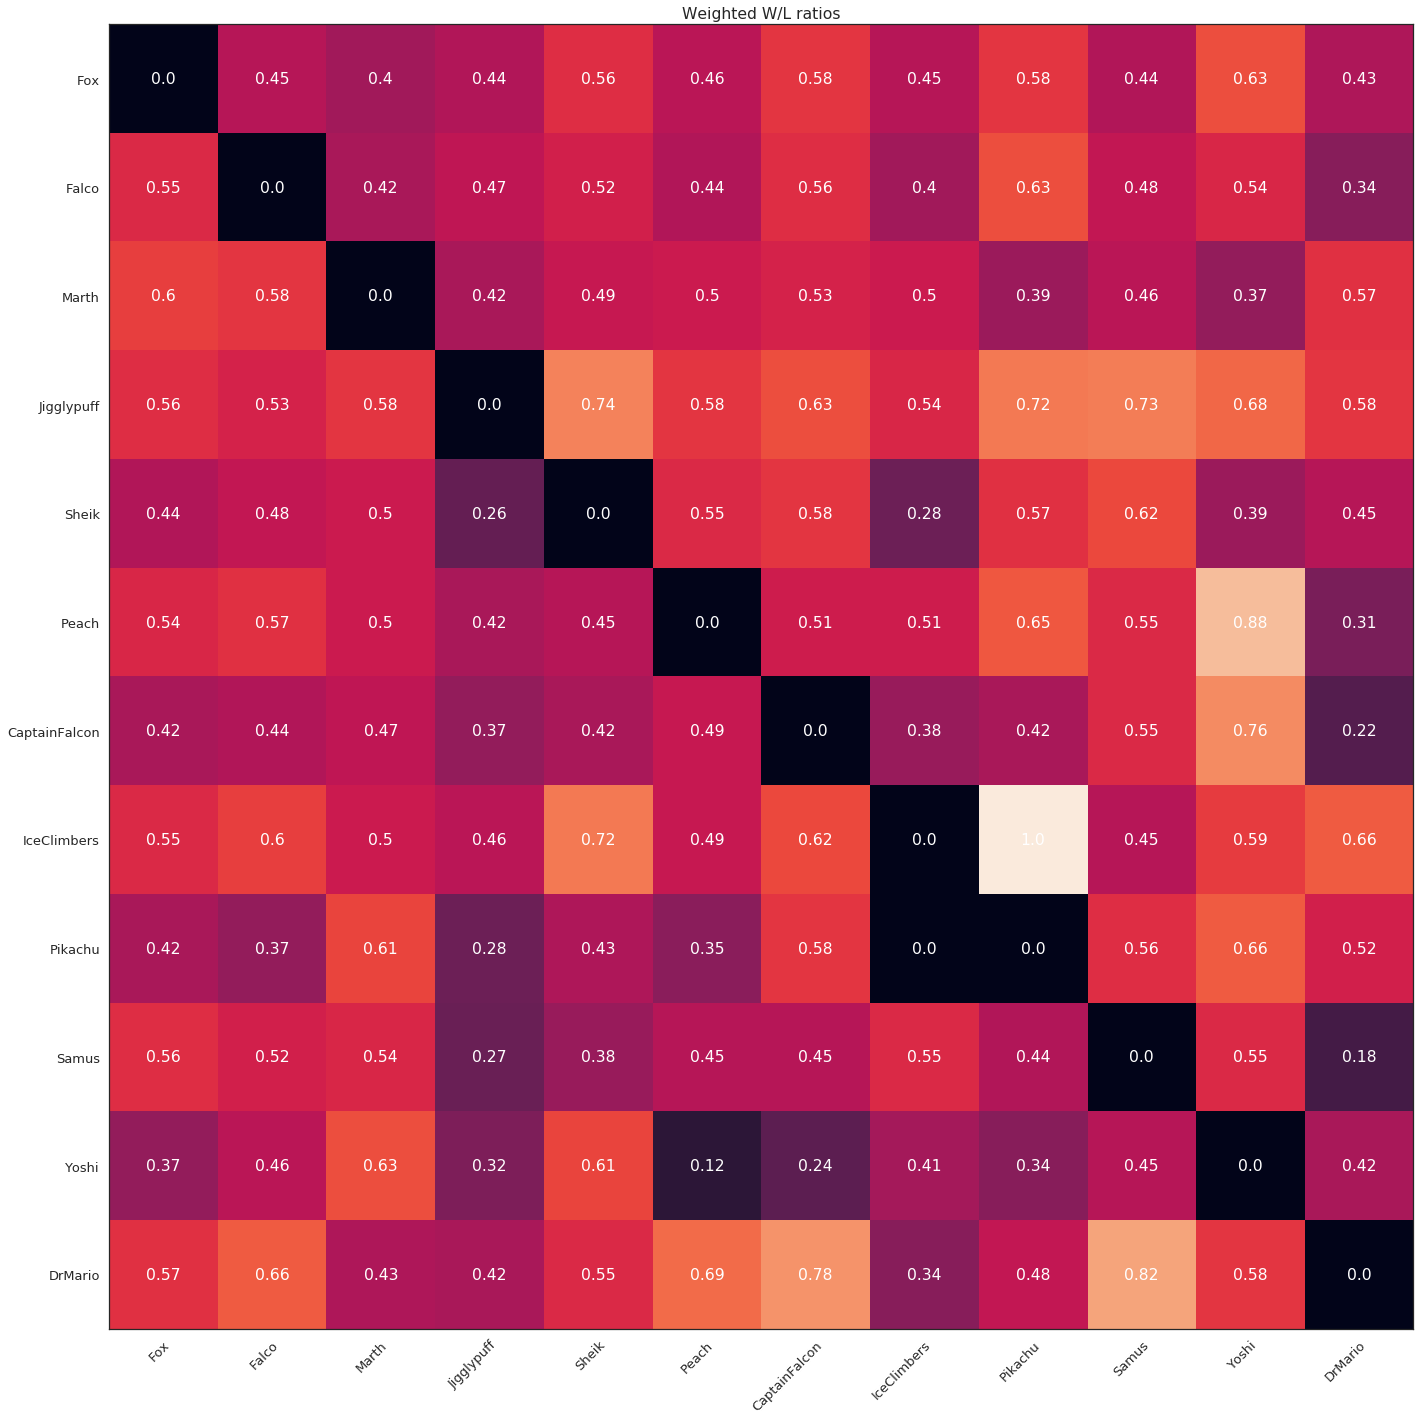

In [307]:
#### HEATMAP GRAPH

fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(wmus)

# We want to show all ticks...
ax.set_xticks(np.arange(len(top_tiers)))
ax.set_yticks(np.arange(len(top_tiers)))
# ... and label them with the respective list entries
ax.set_xticklabels(top_tiers)
ax.set_yticklabels(top_tiers)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(top_tiers)):
    for j in range(len(top_tiers)):
        text = ax.text(j, i, wmus[i, j],
                       ha="center", va="center", color="white")
        


ax.set_title("Weighted W/L ratios")
fig.tight_layout()

plt.show()